### This notebook demonstrated how to use the trained PAE model(s) used in  

### *A Probabilistic Autoencoder for Type Ia Supernovae*

Note that the dataset is not yet public, so most figures as they appear in the paper cannot be directly reproduced. 

Rather, this notebook gives a clear example on how to generate new SNe Ia with a PAE

The trained models are made public, and you will find them in `../outputs/`

### Load necessary packages and data

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
print('devices: ', tf.config.list_physical_devices('GPU') )

tfk  = tf.keras
tfkl = tf.keras.layers
print("TFK Version", tfk.__version__)

# %pip install tensorflow-probability==0.9.0                                                                          
import tensorflow_probability as tfp

tfb  = tfp.bijectors
tfd  = tfp.distributions
print("TFP Version", tfp.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%matplotlib inline

from matplotlib import rcParams
import matplotlib.patches as patches

import numpy as np
import os
import time
from pprint import pprint

import tensorboard.plugins.hparams as HParams
import argparse

from suPAErnova.utils.YParams import YParams
from suPAErnova.utils.data_loader import *
from suPAErnova.utils.calculations import *

from suPAErnova.models.losses import *
from suPAErnova.models.posterior import *

from suPAErnova.models import loader 
from suPAErnova.models import flows

fs = 16

#SET UP FIGURE AESTHETICS 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 18,                                                                                                                                                    
                     'axes.labelsize': 18, 'legend.fontsize': 16, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                     'axes.linewidth': 1.})                                                                                                                                                                    


fs = 16

params = {'text.usetex' : True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica Neue"]}

figdir = '../figures/'

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('viridis')
cmap_scatter = truncate_colormap(cmap, 0.0, 1.0)
cmap_spectra = plt.get_cmap('coolwarm')

tensorflow version:  2.2.0
devices:  []
TFK Version 2.3.0-tf
TFP Version 0.10.1


### Load in trained models and outputs

In [3]:
want_models = True

latent_dim = 3 
kfold = 0

# savefig = True 
savefig = False

file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' 
param_file = '../outputs/params/AE_kfold{:d}_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
                                                                                      

# Load in models, as well as the outputs above
parser = argparse.ArgumentParser()
parser.add_argument("--yaml_config", default='../config/posterior_analysis.yaml', type=str)
parser.add_argument("--config", default='posterior', type=str)
parser.add_argument("--print_params", default=True, action='store_true')

args = parser.parse_args(args=[])

params = YParams(os.path.abspath(args.yaml_config), args.config, print_params=True)            
params['latent_dim'] = latent_dim

#     params = np.load(param_file, allow_pickle=True).item()['parameters']
params['nlayers'] = 12
params['nunit'] =  8

pprint(vars(params))
# Get PAE model"
PAE = loader.PAE(params)


------------------ Configuration ------------------
nchains 25
find_MAP True
stop_ratio 0.0001
max_iterations 2500
max_line_search_iterations 50
tolerance 0.01
run_HMC True
ihmc True
num_burnin_steps 10000
num_samples 10000
num_leapfrog_steps 5
step_size 0.05
dtime_norm 1.0
target_accept_rate 0.651
seed 23581
batch_size 171
train_noise False
vary_mask False
lr 0.001
noise_scale 1.0
mask_vary_frac 0.2
rMAPini False
train_MAP True
train_amplitude True
train_dtime True
train_bias False
savedata True
PROJECT_DIR /global/cscratch1/sd/gstein/machine_learning/sn_project/suPAErnova/
FIG_DIR figures/
DATA_DIR data/
OUTPUT_DIR outputs/
MODEL_DIR outputs/tensorflow_models/
PARAM_DIR outputs/params/
LOG_DIR logs/
verbose True
train_data_file data/train_data_kfold0.npy
test_data_file data/test_data_kfold0.npy
kfold 0
colorlaw_file data/F99_colorlaw.txt
out_file_tail 3stage_train_decorrelate_all_seed2
posterior_file_tail 3stage_train_decorrelate_all_seed2
model_summary True
savefig False
savemodel T

In [37]:
from suPAErnova.make_datasets import make_train_test_data
np.random.seed(13579)


nsn = 2 # number of SN Ia samples to generate
phase_min = -10
phase_max = 40

nspectra = 32

wavelengths, _ = np.loadtxt('../data/F99_colorlaw.txt', unpack=True)
nwavelength = wavelengths.shape[0]

observation_times = np.tile(np.linspace(phase_min, phase_max, 32), (nsamples, 1))[..., np.newaxis] # models were trained on spectra from (-10, 40 days) from peak brightness 
time_normalization = make_train_test_data.time_normalization(observation_times) # models were fed times normalized to the range (0,1)
observation_times_norm = time_normalization.scale(observation_times.copy())

delta_M = np.zeros(nsn)
delta_p = np.zeros(nsn)

mask = np.ones((nsn, nspectra, nwavelength), dtype=np.float32)

u_latent = np.random.normal(size=(nsn, params['latent_dim']+1)).astype(np.float32) # draw Gaussian random variables in U space

z_latent = PAE.flow.bijector(u_latent).numpy() # Transform to z space
z_latent = np.c_[delta_p, delta_M, z_latent] # Concatenate desired magnitude and phase shift

spectra = PAE.decoder((z_latent, observation_times_norm, mask)).numpy() # decode to spectral space


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


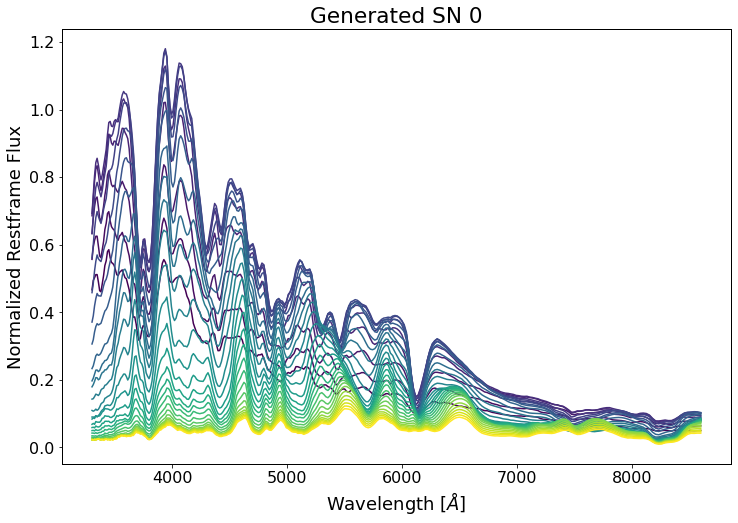

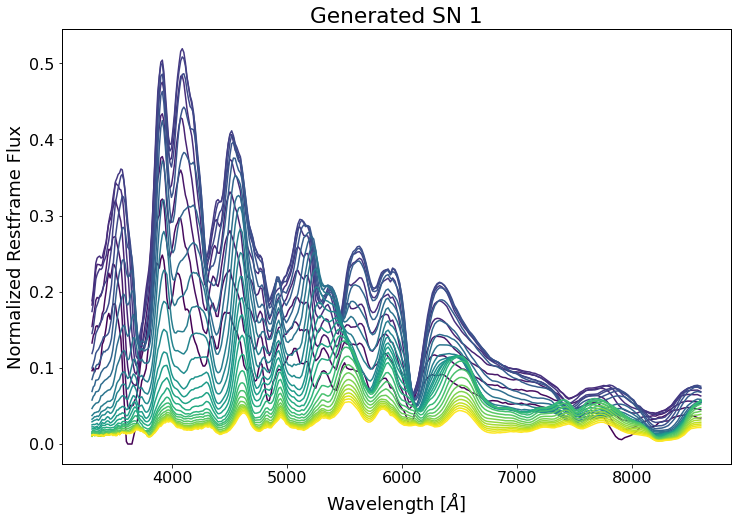

In [39]:
# Simple spectra plots to make sure model is doing what it should be
for isn in range(nsn):
    plt.figure(figsize=(12,8))
    
    for ispec in range(spectra.shape[1]):
        plt.plot(wavelengths, spectra[isn, ispec], color=cmap(observation_times_norm[isn, ispec]))

    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Normalized Restframe Flux')
    plt.title(f'Generated SN {isn}')